# Generate a synthetic lens set from empirical velocity dispersion-effective radius KDE, and intrinsic shape prior

In this notebook, we draw a axisymmetric synthetic lens sample using the 2D Kernel Density Estimaion (KDE) of velocity dispersion - effecitve radius of the [SLACS](https://ui.adsabs.harvard.edu/abs/2008ApJ...682..964B/abstract) lenses, and a intrinsic shape prior from [Li et al, 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...863L..19L/abstract)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 

from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.stats import truncnorm

## The velocity dispersion distribution

Read in the SLACS data from './tableA1.txt'. This is Table 4 in [Bolton et al 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...682..964B/abstract).

In [2]:
data_slacs = pd.read_csv('./tableA1.txt', delim_whitespace=True, comment='#', header=None, on_bad_lines='skip')

# select only the lenses
flag_lens = (data_slacs[17].values.astype('str') == 'A') & (data_slacs[18].values.astype('int') == 0)

data_slacs = data_slacs[flag_lens]

/tmp/ipykernel_2781355/578553144.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_slacs = pd.read_csv('./tableA1.txt', delim_whitespace=True, comment='#', header=None, on_bad_lines='skip')


True
False
True


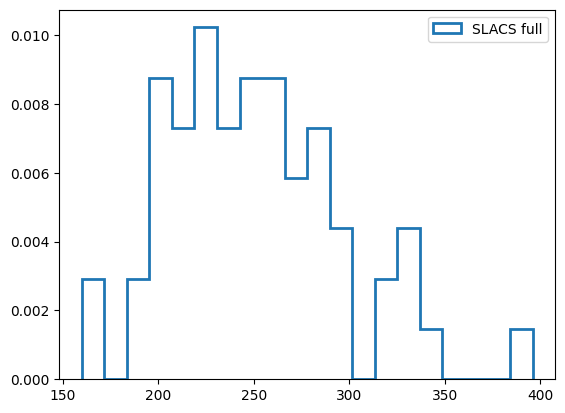

In [3]:
sigma_slacs = data_slacs[11].values.astype('float')
print(np.all(np.isfinite(sigma_slacs)) == True) # check if all values are finite
print(np.all(sigma_slacs > 0.)) # check if all values are positive

sigma_mask = sigma_slacs > 0.
sigma_slacs = sigma_slacs[sigma_mask]
print(np.all(sigma_slacs > 0.)) # check if all values are positive

plt.hist(sigma_slacs, bins = 20, density = True, histtype='step', lw=2, label = 'SLACS full') # histogram of the velocity dispersion

plt.legend()
plt.show()

## Half-light radius

True
True


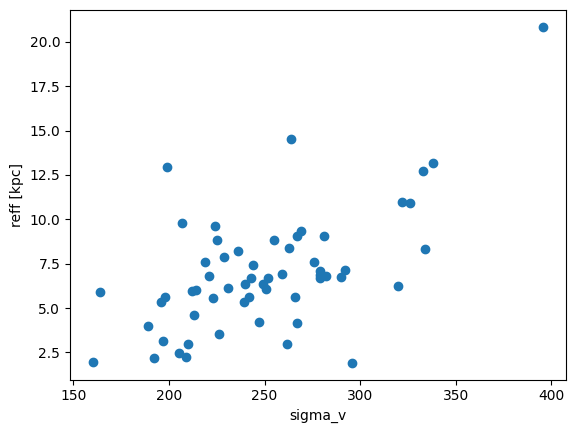

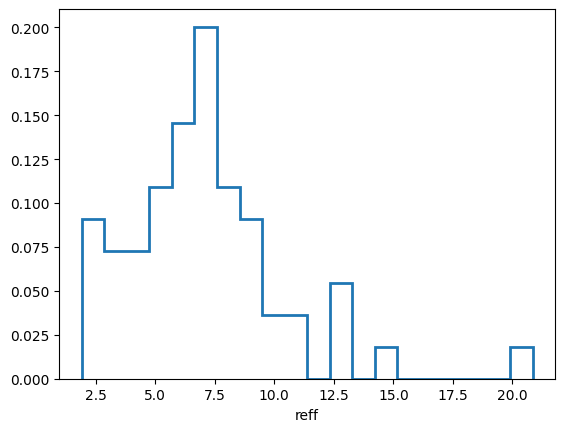

In [4]:
reff_slacs = data_slacs[7].values.astype('float')[sigma_mask]
print(np.all(np.isfinite(reff_slacs)) == True) # check if all values are finite
print(np.all(reff_slacs > 0))  # check if all values are positive

from astropy.cosmology import FlatLambdaCDM
cosmology = FlatLambdaCDM(H0=70, Om0=0.3) # used to convert angular to physical units

# convert effective radius to physical unit
zlens_slacs = data_slacs[3].values.astype('float')
zlens_slacs = zlens_slacs[sigma_mask]
Dd = cosmology.angular_diameter_distance(zlens_slacs)
reff_kpc = (reff_slacs / 3600 * np.pi / 180 * Dd * 1e3).value # convert from arcsec to kpc

plt.figure()
plt.scatter(sigma_slacs, reff_kpc)
plt.xlabel('sigma_v')
plt.ylabel('reff [kpc]')
plt.show()

plt.figure()
plt.hist(reff_kpc, bins = 20, density = True, histtype='step', lw=2, label = 'SLACS full')

plt.xlabel('reff')
plt.show()



## Sample the velocity dispersion and the effective radius on a grid

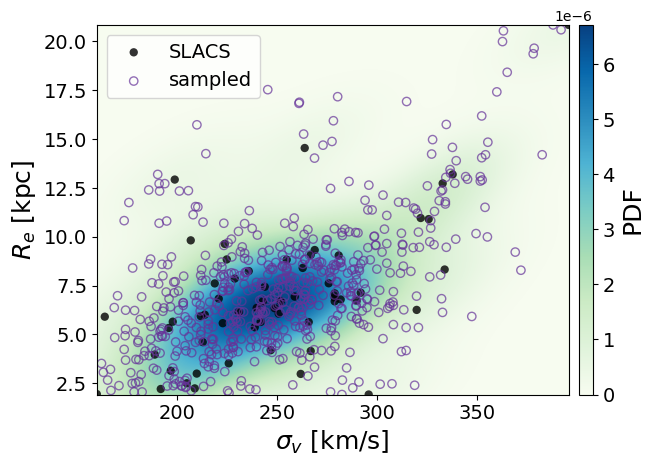

In [5]:
# 2d kde estimation of [sigma, reff]

data = np.vstack([sigma_slacs, reff_kpc])
data_kde = gaussian_kde(data, bw_method='silverman')

sigma_min = sigma_slacs.min()
sigma_max = sigma_slacs.max()
reff_min = reff_kpc.min()
reff_max = reff_kpc.max()

grid_x, grid_y = np.mgrid[sigma_min: sigma_max: 1000j, reff_min: reff_max: 1000j]
grid_ravel = np.vstack([grid_x.ravel(), grid_y.ravel()])
data_kde_eval = np.reshape(data_kde(grid_ravel).T, grid_x.shape)

# normalize the density
data_kde_eval = data_kde_eval / np.sum(data_kde_eval)


# randomly sample from the grid
sample_indices = np.random.choice(
    np.arange(data_kde_eval.size),
    size=600,
    p=data_kde_eval.ravel()
)


sigma_draw, reff_draw = grid_ravel[0][sample_indices], grid_ravel[1][sample_indices]


# plotting the synthetic data I used in the paper
data_sampled = np.load('./synthetic_oblate.npy') # this is one realization of the draws. The code to saving this file is in the next next cell
sigma_data, reff_data = data_sampled[:2] # third dimension is the intrinsic axis ratio

fig, ax = plt.subplots()
im = ax.imshow(np.rot90(data_kde_eval), cmap=plt.cm.GnBu,
          extent=[sigma_min, sigma_max, reff_min, reff_max])
ax.scatter(sigma_slacs, reff_kpc, c = 'k', alpha = 0.8, edgecolors = 'none', label = 'SLACS')
ax.set_xlim([sigma_min, sigma_max])
ax.set_ylim([reff_min, reff_max])
ax.set_aspect('auto')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)

ax.scatter(sigma_data, reff_data, facecolors= 'none', edgecolors='rebeccapurple', alpha = 0.7, label = 'sampled')
ax.set_xlabel(r'$\sigma_v$ [km/s]', size = 18)
ax.set_ylabel(r'$R_e$ [kpc]', size = 18)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('PDF', size = 18)

for ax1 in fig.axes:
    ax1.tick_params(labelsize = 14)

ax.legend(prop = {'size': 14})
# plt.savefig('./synthetic_lens_slacs_kde.pdf', dpi=300, bbox_inches='tight')

plt.show()

## The intrinsic shape distribution

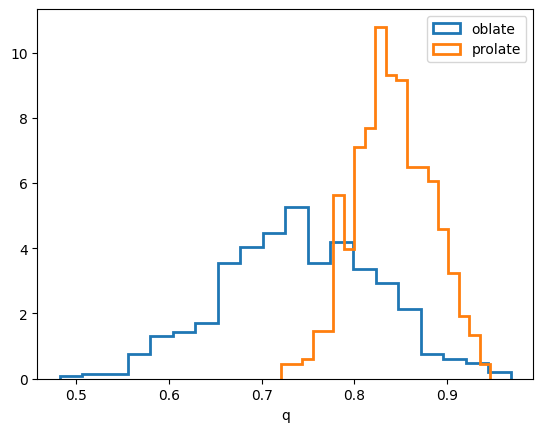

In [6]:
def qintr_prior(mu, sigma, num): # sample q_intr from truncated Gaussian prior
    lo_lim, hi_lim = 0, 1
    lo_transformed = (lo_lim - mu) / sigma
    hi_transformed = (hi_lim - mu) / sigma
    qintr_prior = truncnorm(lo_transformed, hi_transformed, loc = mu, scale = sigma)
    return qintr_prior.rvs(size = num)

mu_qintr_oblate, sigma_qintr_oblate = 0.74, 0.08 # from Li et al 2018
mu_qintr_prolate, sigma_qintr_prolate = 0.84, 0.04 # from Li et al 2018

qintr_oblate = qintr_prior(mu_qintr_oblate, sigma_qintr_oblate, 600)
qintr_prolate = qintr_prior(mu_qintr_prolate, sigma_qintr_prolate, 600)

plt.hist(qintr_oblate, histtype='step', lw=2, label = 'oblate', density = True, bins = 20)
plt.hist(qintr_prolate, histtype='step', lw=2, label = 'prolate', density = True, bins = 20)
plt.xlabel('q')
plt.legend()
plt.show()

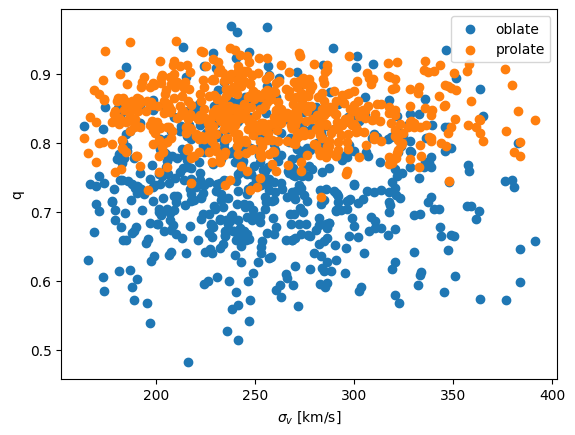

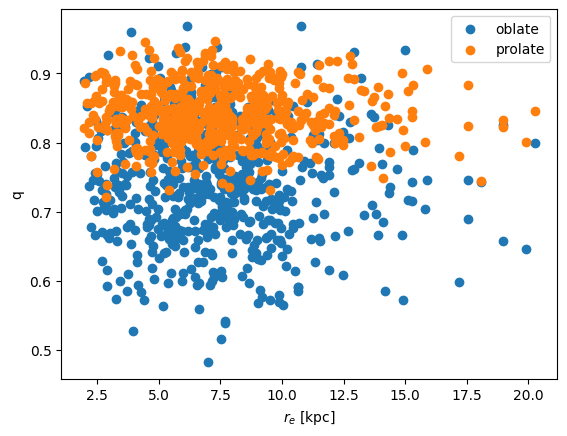

In [7]:
data_oblate = np.vstack([sigma_draw, reff_draw, qintr_oblate])
data_prolate = np.vstack([sigma_draw, reff_draw, qintr_prolate])

# plot the synthetic data
plt.scatter(data_oblate[0], data_oblate[2], label = 'oblate')
plt.scatter(data_prolate[0], data_prolate[2], label = 'prolate')
plt.xlabel(r'$\sigma_v$ [km/s]')
plt.ylabel('q')
plt.legend()
plt.show()

plt.figure()
plt.scatter(data_oblate[1], data_oblate[2], label = 'oblate')
plt.scatter(data_prolate[1], data_prolate[2], label = 'prolate')
plt.xlabel(r'$r_{e}$ [kpc]')
plt.ylabel('q')
plt.legend()
plt.show()

save_sampled_data = False 

if save_sampled_data:
    np.save('./synthetic_oblate.npy', data_oblate)
    np.save('./synthetic_prolate.npy', data_prolate)